In [3]:
%load_ext autoreload

In [4]:
%autoreload 2
import cmath
from datetime import datetime
from kneed import KneeLocator
from matplotlib import colors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from neural_analysis.matIO import loadmat
from neural_analysis import spectra
from nolitsa import delay
import numpy as np
import os
import pandas as pd
import re
import scipy
from sdeint import itoint
from scipy.integrate import odeint
from scipy.signal import butter, lfilter
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.tsa.api import AutoReg, VAR
import sys
import time
from tqdm.auto import tqdm
import traceback as tb

plt.style.use('../../sci_style.py')

sys.path.append('../../..')
from iaaft import surrogates
from dynamical_systems_models import construct_dictionary, embed_signal, perform_stability_analysis, get_stability_results, compute_EDMD, predict_EDMD, compute_VAR_p, compute_VAR_p_over_lamb, predict_VAR_p
from nld_utils import calculate_fnn_stat, get_nn_indices
from plot import plot_individual_areas, plot_multipopulation
from up_down import get_up_down
from utils import compute_summary_statistics, get_data_class, get_result_path, load, load_session_data, run_window_selection, save

In [452]:
hyp_params = {}
hyp_params['num_init_conds'] = 200
hyp_params['time_final'] = 500
hyp_params['delta_t'] = 0.1
hyp_params['num_time_steps'] = int(hyp_params['time_final']/hyp_params['delta_t'])
hyp_params['mu'] = 5

# VDP Oscillator Data

In [455]:
def vdp(t, x):
        return [x[1], mu * (1 - x[0] ** 2) * x[1] - x[0]]
mu = hyp_params['mu']
icx = np.random.uniform(-2, 2, hyp_params['num_init_conds'])
icy = np.random.uniform(-2, 2, hyp_params['num_init_conds'])
tspan = np.array([0, hyp_params['time_final']])
dts = np.arange(0, hyp_params['time_final'], hyp_params['delta_t'])
X = np.zeros(shape=(hyp_params['num_init_conds'], 2, hyp_params['num_time_steps']))
for ii, ic in tqdm(enumerate(zip(icx, icy)), total=hyp_params['num_init_conds']):
    tmp = scipy.integrate.solve_ivp(vdp, t_span=tspan, y0=ic, method='RK45', t_eval=dts)
    X[ii, :, :] = tmp.y

  0%|          | 0/200 [00:00<?, ?it/s]

In [456]:
X = np.transpose(X, (0, 2, 1))

In [457]:
train_pct = 0.8
test_pct = 1 - train_pct
# train_pct = 0.05
# test_pct = 0.02

In [458]:
shuffled_inds = np.random.choice(np.arange(X.shape[0]), size=(X.shape[0],), replace=False)

In [476]:
train_inds = shuffled_inds[:int(train_pct*X.shape[0])]
test_inds = shuffled_inds[int(train_pct*X.shape[0]):int((train_pct + test_pct)*X.shape[0])]

# train_inds = shuffled_inds[:4]
# test_inds = shuffled_inds[4:5]

In [477]:
train_data = X[train_inds]
test_data = X[test_inds]

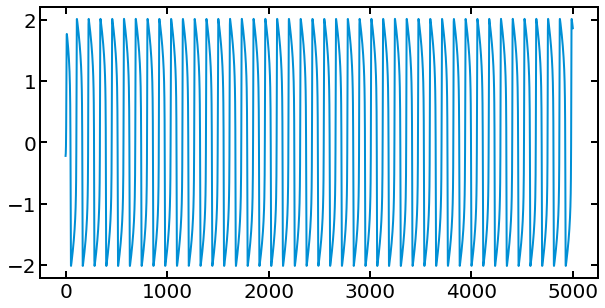

In [478]:
plt.plot(train_data[0][:, 0])

# Class

In [479]:
class KoopmanModels:
    def __init__(self, data, p=None, svd=True, verbose=False):
        self.data = data
        self.n_trajectories = data.shape[0]
        self.window = data.shape[1]
        self.n = data.shape[2]
        self.p = p
        
        if p is not None:
            self.compute_hankel(verbose=verbose)
            if svd:
                self.compute_svd(verbose=verbose)
            else:
                self.U = None
                self.S = None
                self.V = None
                self.S_mat = None
                self.S_mat_inv = None
                self.knee = None
        else:
            self.H = None
        
        self.A_var_p = None
        self.H_var_p = None
        self.eigvals_var_p = None
        
        self.r = None
        self.A_havok_dmd = None
        self.V_havok_dmd = None
        self.H_havok_dmd = None
        self.eigvals_havok_dmd = None
        
#         self.A_havok_forcing = None
#         self.B_havok_forcing = None
#         self.V_havok_forcing = None
#         self.H_havok_forcing = None
        
    def compute_hankel(self, p=None, verbose=False):
        if verbose:
            print("Computing Hankel matrix ...")
        if p is None and self.p is None:
            raise ValueError("Embedding dim p has not been provided.")
        elif p is not None:
            self.p = p
        else: # p is None and self.p is not None
            p = self.p
        
        H = np.zeros((self.n_trajectories, self.window - p + 1, p*self.n))
        for ii in range(self.data.shape[0]):
            H[ii] = embed_signal(self.data[ii], p, 1, direction='reverse')
            self.H = H
        
        if verbose:
            print("Hankel matrix computed!")
        
    def compute_svd(self, verbose=False):
        if verbose:
            print("Computing SVD on Hankel matrix ...")
        
        self.U = np.zeros((self.n_trajectories, self.p*self.n, self.p*self.n))
        self.S = np.zeros((self.n_trajectories, self.p*self.n))
        self.V = np.zeros((self.n_trajectories, self.window - self.p + 1, self.p*self.n))
        
        self.S_mat = np.zeros((self.n_trajectories, self.p*self.n, self.p*self.n))
        self.S_mat_inv = np.zeros((self.n_trajectories, self.p*self.n, self.p*self.n))
        
        self.knee = np.zeros(self.n_trajectories)
        
        for ii in tqdm(range(self.n_trajectories), disable=not verbose):
            u, s, vh = np.linalg.svd(self.H[ii].T, full_matrices=False)
            
            v = vh.T
            self.U[ii] = u
            self.S[ii] = s
            self.V[ii] = v

            self.S_mat[ii][np.arange(len(s)), np.arange(len(s))] = s
        
            self.S_mat_inv[ii][np.arange(len(s)), np.arange(len(s))] = 1/s
        
            self.knee = KneeLocator(np.arange(len(s)), s, S=40, curve='convex', direction='decreasing').knee
        
        if verbose:
            print("SVD complete!")
    
    def compute_var_p(self, verbose=False):
        if verbose:
            print("Computing least squares fit to VAR(p) ...")
        coefs = np.linalg.lstsq(self.H[:-1], self.H[1:, :self.n], rcond=1e-14)[0].T
        if verbose:
            print("Least squares complete!")
            print("Constructing transition matrix and train predictions ...")
        A_mat = np.zeros((self.H.shape[1], self.H.shape[1]))
        for i in range(self.p):
            A_mat[:self.n, :][:, i*self.n:(i + 1)*self.n] = coefs[:, i*self.n:(i + 1)*self.n]
            if i < self.p - 1:
                A_mat[(i + 1)*self.n:(i + 2)*self.n, :][:, i*self.n:(i + 1)*self.n] = np.eye(self.n)
        self.A_var_p = A_mat
        H_var_p = (A_mat @ self.H[:-1].T).T
        self.H_var_p = np.vstack([self.H[[0]], H_var_p])
        if verbose:
            print("Train predictions complete!")
            print("Computing eigenvalues ...")
        
        self.eigvals_var_p = np.linalg.eigvals(A_mat)
    
        if verbose:
            print("Eigenvalues computed!")
            
    def compute_havok_dmd(self, r=None, forcing=False, s=1, verbose=False):
        if verbose:
            print("Computing least squares fits to HAVOK DMD ...")
        if r is None:
            r = self.knee.mean()*2
            r = int(r)
        self.r = r
        
        self.A_havok_dmd = np.zeros((self.n_trajectories, r, r))
        self.V_havok_dmd = np.zeros((self.n_trajectories, self.window - self.p + 1, r))
        self.H_havok_dmd = np.zeros((self.n_trajectories, self.window - self.p + 1, self.p*self.n))
        self.eigvals_havok_dmd = np.zeros((self.n_trajectories, r), dtype=complex)
        
        for ii in tqdm(range(self.n_trajectories), disable=not verbose):
            A = np.linalg.lstsq(self.V[ii][:-1, :r], self.V[ii][1:, :r], rcond=1e-14)[0].T
            self.A_havok_dmd[ii] = A
            if verbose > 1:
                print("Least squares complete!")
                print("Computing train predictions ...")
        
            V_havok_dmd = (A @ self.V[ii][:-1, :r].T).T
            V_havok_dmd = np.vstack([self.V[ii][[0], :r], V_havok_dmd])
            self.V_havok_dmd[ii] = V_havok_dmd
            H_havok_dmd = (self.U[ii] @ self.S_mat[ii][:, :r] @ V_havok_dmd.T).T
            self.H_havok_dmd[ii] = H_havok_dmd
        
            if verbose > 1:
                print("Train predictions complete!")
                print("Computing eigenvalues ...")

            self.eigvals_havok_dmd[ii] = np.linalg.eigvals(A)

            if verbose > 1:
                print("Eigenvalues computed!")
            
#         if forcing:            
#             B = A[:r-s, r-s:r]
#             A = A[:r-s, :r-s]
#             self.A_havok_forcing = A
#             self.B_havok_forcing = B
            
# #             # not chained
# #             V_havok_forcing = (A @ self.V[:-1, :r-s].T).T + (B @ self.V[:-1, r-s:r].T).T
# #             V_havok_forcing = np.vstack([self.V[[0], :r-s], V_havok_forcing])
# #             self.V_havok_forcing = V_havok_forcing 
            
#             # chained
#             V_havok_forcing = np.zeros(koopman.V[:, :r-s].shape)
#             V_havok_forcing[0] = koopman.V[0, :r-s]
#             for t in range(1, koopman.V.shape[0]):
#                 V_havok_forcing[t] = A @ V_havok_forcing[t-1] + B @ koopman.V[t-1, r-s:r].T
#             self.V_havok_forcing = V_havok_forcing
                
#             self.H_havok_forcing = (self.U @ self.S_mat[:, :r-s] @ V_havok_forcing.T).T
            
#             self.eigvals_havok_forcing = np.linalg.eigvals(A)
            
    def predict_var_p(self, test_signal, tail_bite=False):
        H_test = embed_signal(test_signal, self.p, 1, direction='reverse') 
        
        if tail_bite:
            pass
        else:
            H_test_var_p = (self.A_var_p @ H_test[:-1].T).T
            H_test_var_p = np.vstack([H_test[[0]], H_test_var_p])
        
        return H_test_var_p, H_test

    def predict_havok_dmd(self, test_data, tail_bite=False, verbose=False):
        H_test_havok_dmd = np.zeros((test_data.shape[0], test_data.shape[1] - self.p + 1, self.p*self.n))
        H_test = np.zeros((test_data.shape[0], test_data.shape[1] - self.p + 1, self.p*self.n))
        V_test_havok_dmd = np.zeros((test_data.shape[0], test_data.shape[1] - self.p + 1, self.r))
        V_test = np.zeros((test_data.shape[0], test_data.shape[1] - self.p + 1, self.r))
        
        for ii in tqdm(range(test_data.shape[0]), disable=not verbose):
            traj_ind = np.argmin(((test_data[ii, 0] - self.data[:, 0])**2).mean(axis=1))
            H_test[ii] = embed_signal(test_data[ii], self.p, 1, direction='reverse')
            V_test[ii] = (self.S_mat_inv[traj_ind][:self.r] @ self.U[traj_ind].T @ H_test[ii].T).T

            if tail_bite:
                V_test_havok_dmd[ii][0] = V_test[ii][0]
                for t in range(1, V_test.shape[1]):
                    V_test_havok_dmd[ii][t] = self.A_havok_dmd[traj_ind] @ V_test_havok_dmd[ii][t - 1]
            else:
                V_test_havok_dmd_ = (self.A_havok_dmd[traj_ind] @ V_test[ii][:-1].T).T
                V_test_havok_dmd[ii] = np.vstack([V_test[ii][[0], :self.r], V_test_havok_dmd_])
            H_test_havok_dmd[ii] = (self.U[traj_ind] @ self.S_mat[traj_ind][:, :self.r] @ V_test_havok_dmd[ii].T).T
        
        return H_test_havok_dmd, H_test, V_test_havok_dmd, V_test

In [480]:
p = 75
verbose = True

In [481]:
koopman = KoopmanModels(train_data, p=p, verbose=verbose)

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...


  0%|          | 0/160 [00:00<?, ?it/s]

SVD complete!


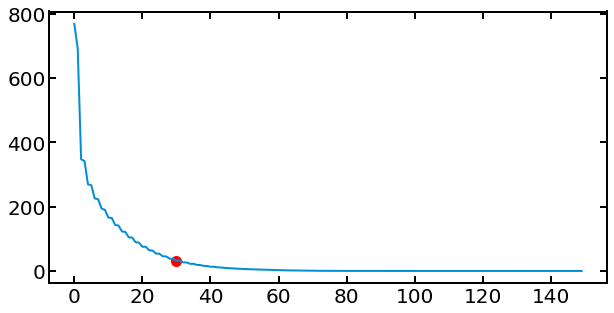

In [482]:
plt.plot(koopman.S.mean(axis=0))
plt.scatter(koopman.knee, koopman.S.mean(axis=0)[koopman.knee], c='red', s=100)
plt.show()

In [483]:
koopman.compute_havok_dmd(verbose=verbose, r=koopman.knee*4)

Computing least squares fits to HAVOK DMD ...


  0%|          | 0/160 [00:00<?, ?it/s]

In [484]:
tail_bite = True
H_test_havok_dmd, H_test, V_test_havok_dmd, V_test = koopman.predict_havok_dmd(train_data, tail_bite=tail_bite, verbose=verbose)

  0%|          | 0/160 [00:00<?, ?it/s]

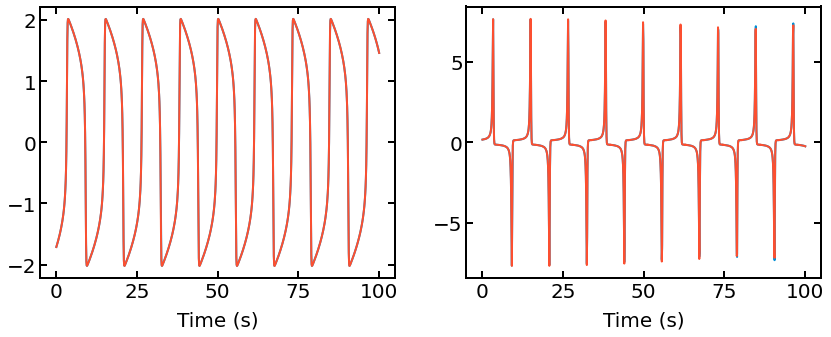

In [485]:
start = 1
end = 1001
plt.figure(figsize=(14, 5))
time_vals = np.arange(H_test.shape[1])*hyp_params['delta_t']
plt.subplot(1, 2, 1)
plt.plot(time_vals[start:end], H_test[0, start:end, 0])
plt.plot(time_vals[start:end], H_test_havok_dmd[0, start:end, 0])
plt.xlabel('Time (s)')
plt.subplot(1, 2, 2)
plt.plot(time_vals[start:end], H_test[0, start:end, 1])
plt.plot(time_vals[start:end], H_test_havok_dmd[0, start:end, 1])
plt.xlabel('Time (s)')
# plt.xlim([0, 200])
plt.show()

  0%|          | 0/40 [00:00<?, ?it/s]

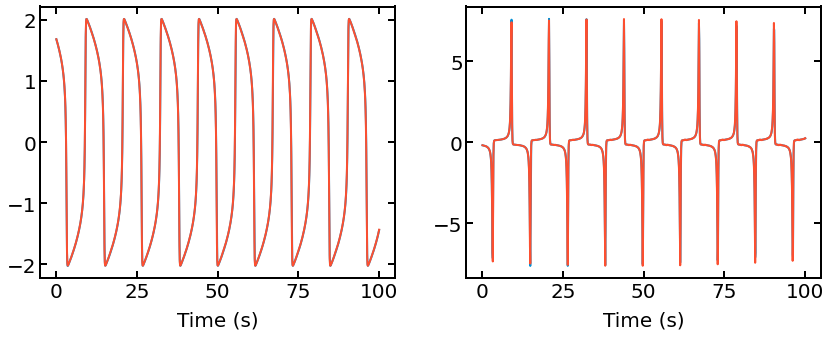

In [486]:
tail_bite = True
H_test_havok_dmd, H_test, V_test_havok_dmd, V_test = koopman.predict_havok_dmd(test_data, tail_bite=tail_bite, verbose=verbose)

start = 1
end = 1001
plt.figure(figsize=(14, 5))
time_vals = np.arange(H_test.shape[1])*hyp_params['delta_t']
plt.subplot(1, 2, 1)
plt.plot(time_vals[start:end], H_test[0, start:end, 0])
plt.plot(time_vals[start:end], H_test_havok_dmd[0, start:end, 0])
plt.xlabel('Time (s)')
plt.subplot(1, 2, 2)
plt.plot(time_vals[start:end], H_test[0, start:end, 1])
plt.plot(time_vals[start:end], H_test_havok_dmd[0, start:end, 1])
plt.xlabel('Time (s)')
# plt.xlim([0, 200])
plt.show()

In [487]:
koopman.H.shape
ii = 0
T_pred = 4000
epsilon = 1e-12

In [488]:
# w_hat = np.zeros((T_pred, koopman.n))
w_hat = np.zeros((T_pred, koopman.p*koopman.n))
w_norms = np.zeros(T_pred)
# w = np.random.randn(koopman.n)
w = np.random.randn(koopman.p*koopman.n)
w_norms[0] = np.linalg.norm(w)
w_hat[0] = w/w_norms[0]

# ws = np.zeros((T_pred, koopman.n))
# ws[0] = w

In [489]:
A = koopman.U[ii] @ koopman.S_mat[ii][:, :koopman.r] @ koopman.A_havok_dmd[ii] @ koopman.S_mat_inv[ii][:koopman.r] @ koopman.U[ii].T

In [490]:
for t in tqdm(range(1, T_pred)):
    h = koopman.H[ii][t - 1]
    h_perturbed = h + epsilon*w_hat[t-1]
    w = (A @ h_perturbed) - (A @ h)
    
#     h_perturbed = h.copy()
#     h_perturbed[:2] += epsilon*w_hat[t - 1]
#     w = (A @ h_perturbed)[:2] - (A @ h)[:2]
#     w = (A @ h_perturbed)[:2] - koopman.H[ii][t][:2]

    w_norms[t] = np.linalg.norm(w)
    w_hat[t] = w/w_norms[t]

  0%|          | 0/3999 [00:00<?, ?it/s]

In [491]:
np.log(w_norms[drop_initial:]/epsilon).sum()*(1/((T_pred - drop_initial)*hyp_params['delta_t']))

0.016181300988404153

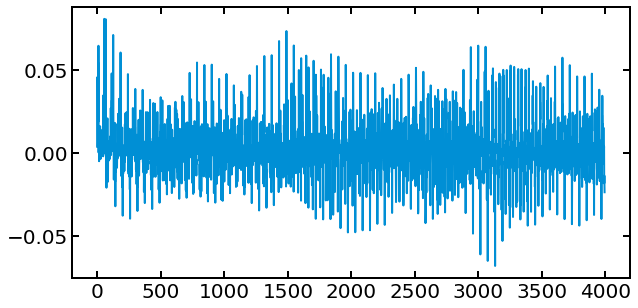

In [492]:
plt.plot(np.log(w_norms[drop_initial:]/epsilon))

# Old Approach

In [493]:
def compute_lyapunov_spectrum(signal, A, dims=None, T_pred=None, epsilon=1, tau=1, dt=1, drop_initial=5, return_full=False, verbose=False):
    if dims is None:
        dims = signal.shape[1]
    if T_pred is None:
        T_pred = signal.shape[0]
    
    d = signal.shape[1]
    w = np.zeros((T_pred, d, dims))
    w_norms = np.zeros((T_pred, dims))
    Q, R = np.linalg.qr(np.random.randn(d, dims))
    sign_diag = np.sign(np.diag(R))
    sign_diag[np.where(sign_diag == 0)] = 1
    sign_diag = np.diag(sign_diag)
    Q = np.dot(Q, sign_diag)
    R = np.dot(sign_diag, R)

    w[0] = Q
    w_norms[0] = np.diag(R)
    
    for t in tqdm(range(1, T_pred), disable=not verbose):
#         Q, R = np.linalg.qr(A @ (signal[t-1].reshape(-1, 1) + epsilon*w[t-1]) - signal[t].reshape(-1, 1))
        y1 = signal[t-1].reshape(-1, 1) + epsilon*w[t-1]
        y0 =  signal[t - 1].reshape(-1, 1)
        for t_ in range(tau):
            y1 = A @ y1
            y0 = A @ y0
        Q, R = np.linalg.qr(y1 - y0)
#         Q, R = np.linalg.qr(A @ (signal[t-1].reshape(-1, 1) + epsilon*w[t-1]) - (A @ signal[t - 1]).reshape(-1, 1))
        sign_diag = np.sign(np.diag(R))
        sign_diag[np.where(sign_diag == 0)] = 1
        sign_diag = np.diag(sign_diag)
        Q = np.dot(Q, sign_diag)
        R = np.dot(sign_diag, R)
        w[t] = Q
        w_norms[t] = np.diag(R)
    
    lyap_spec = np.log(w_norms[drop_initial:]/epsilon).sum(axis=0)*(1/((w_norms.shape[0] - drop_initial)*dt*tau))

    if return_full:
        return lyap_spec, w, w_norms
    else:
        return lyap_spec

In [494]:
dims = koopman.r
epsilon = 1e-12
return_full = False
verbose = False
epsilon = 1e-12
tau = 1
lyap_specs = np.zeros((koopman.n_trajectories, dims))
for ii in tqdm(range(koopman.n_trajectories)):
#     lyap_specs[ii] = compute_lyapunov_spectrum(koopman.V[ii][:, :koopman.r], koopman.A_havok_dmd[ii], dims=dims, epsilon=epsilon, dt=hyp_params['delta_t'], return_full=return_full, verbose=verbose)
    A = koopman.U[ii] @ koopman.S_mat[ii][:, :koopman.r] @ koopman.A_havok_dmd[ii] @ koopman.S_mat_inv[ii][:koopman.r] @ koopman.U[ii].T
    lyap_specs[ii] = compute_lyapunov_spectrum(koopman.H[ii], A, dims=dims, epsilon=epsilon, tau=tau, dt=hyp_params['delta_t'], return_full=return_full, verbose=verbose)

  0%|          | 0/160 [00:00<?, ?it/s]

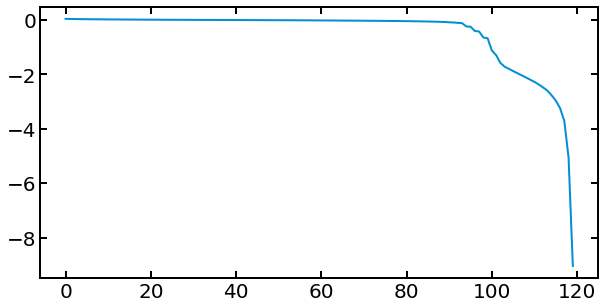

In [495]:
plt.plot(lyap_specs.mean(axis=0)[:np.linalg.matrix_rank(A)])

In [496]:
lyap_specs[:, -1]

array([ -8.74810072,  -7.90419295,  -3.55324752, -16.0907549 ,
       -13.20593496, -13.4249354 ,  -9.63675573,  -7.53455344,
       -10.20045443,  -3.57891679,  -2.73421408,  -7.72462679,
        -9.43311036,  -9.11688741, -10.83078892, -11.01846478,
        -9.77462899, -10.1708464 ,  -3.80702636,  -9.98609296,
        -8.16452702,  -2.64129815, -12.13056072, -14.27762645,
        -1.62542588,  -9.13292306,  -9.90391393, -10.2697282 ,
       -20.2404004 ,  -6.75411065, -10.59558996,  -8.39576491,
        -9.97514574,  -7.7776779 ,  -9.11013038,  -3.97977861,
        -8.62767977,  -3.42221532, -18.89268018,  -9.163176  ,
       -10.15420718, -11.31832068,  -2.03620478, -10.6471011 ,
        -8.85556355,  -9.27599686,  -4.00309358,  -8.79737392,
        -4.54667961, -10.22622751, -10.37599984,  -9.84600662,
        -7.89195649,  -8.52810436,  -3.06018647, -17.23351542,
        -9.33816731, -16.78009778, -12.7811238 ,  -8.2735265 ,
       -11.43811575,  -9.88757041,  -1.7283493 ,  -7.84

# All Sim

In [497]:
mu_vals=np.array([0.001, 0.01, 0.1, 0.2, 0.5, 0.75, 1, 1.25, 2, 3, 4, 5])

In [498]:
results = {}
for mu in tqdm(mu_vals):
    hyp_params = {}
    hyp_params['num_init_conds'] = 200
    hyp_params['time_final'] = 500
    hyp_params['delta_t'] = 0.1
    hyp_params['num_time_steps'] = int(hyp_params['time_final']/hyp_params['delta_t'])

    def vdp(t, x):
        return [x[1], mu * (1 - x[0] ** 2) * x[1] - x[0]]
    icx = np.random.uniform(-2, 2, hyp_params['num_init_conds'])
    icy = np.random.uniform(-2, 2, hyp_params['num_init_conds'])
    tspan = np.array([0, hyp_params['time_final']])
    dts = np.arange(0, hyp_params['time_final'], hyp_params['delta_t'])
    X = np.zeros(shape=(hyp_params['num_init_conds'], 2, hyp_params['num_time_steps']))
    for ii, ic in tqdm(enumerate(zip(icx, icy)), total=hyp_params['num_init_conds']):
        tmp = scipy.integrate.solve_ivp(vdp, t_span=tspan, y0=ic, method='RK45', t_eval=dts)
        X[ii, :, :] = tmp.y

    X = np.transpose(X, (0, 2, 1))

    train_pct = 0.8
    test_pct = 1 - train_pct
    # train_pct = 0.05
    # test_pct = 0.02

    shuffled_inds = np.random.choice(np.arange(X.shape[0]), size=(X.shape[0],), replace=False)

    train_inds = shuffled_inds[:int(train_pct*X.shape[0])]
    test_inds = shuffled_inds[int(train_pct*X.shape[0]):int((train_pct + test_pct)*X.shape[0])]

    # train_inds = shuffled_inds[:4]
    # test_inds = shuffled_inds[4:5]

    train_data = X[train_inds]
    test_data = X[test_inds]
    
    p = 75
    verbose = False

    koopman = KoopmanModels(train_data, p=p, verbose=verbose)
    koopman.compute_havok_dmd(verbose=verbose, r=koopman.knee*4)
    
    dims = koopman.r
    epsilon = 1e-12
    return_full = False
    verbose = False
    epsilon = 1e-12
    tau = 1
    lyap_specs = np.zeros((koopman.n_trajectories, dims))
    for ii in tqdm(range(koopman.n_trajectories)):
    #     lyap_specs[ii] = compute_lyapunov_spectrum(koopman.V[ii][:, :koopman.r], koopman.A_havok_dmd[ii], dims=dims, epsilon=epsilon, dt=hyp_params['delta_t'], return_full=return_full, verbose=verbose)
        A = koopman.U[ii] @ koopman.S_mat[ii][:, :koopman.r] @ koopman.A_havok_dmd[ii] @ koopman.S_mat_inv[ii][:koopman.r] @ koopman.U[ii].T
        lyap_specs[ii] = compute_lyapunov_spectrum(koopman.H[ii], A, dims=dims, epsilon=epsilon, tau=tau, dt=hyp_params['delta_t'], return_full=return_full, verbose=verbose)
    
    results[f"mu = {mu:.3f}"] = dict(
        train_data=train_data,
        koopman=koopman,
        lyap_specs=lyap_specs
    )

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

is this just the same as propagating the perturbation vector through the system?

yes, it is .... but that's okay

what if we want to do variable times? ....


In [499]:
results.keys()

dict_keys(['mu = 0.001', 'mu = 0.010', 'mu = 0.100', 'mu = 0.200', 'mu = 0.500', 'mu = 0.750', 'mu = 1.000', 'mu = 1.250', 'mu = 2.000', 'mu = 3.000', 'mu = 4.000', 'mu = 5.000'])

In [510]:
mean_lyap_specs = [res['lyap_specs'].mean() for res in results.values()]
min_lyap_specs = [res['lyap_specs'].min() for res in results.values()]

In [507]:
def lambda_2(mu):
    if mu < 2:
        return -mu  - (1/16)*(mu ** 3) + (263/18432)*(mu ** 5)
    elif mu >= 2 and mu <= 4:
        return (-1.2 + (mu - 2)*(-0.1))*mu
    elif mu > 4 and mu <= 5:
        return (-1.4 + (mu - 4)*(-0.05))*mu
#     elif mu == 2:
#         return -1.2*mu
#     elif mu == 3:
#         return -1.3*mu
#     elif mu == 4:
#         return -1.4*mu
#     elif mu == 5:
#         return -1.45*mu
    else:
        return None
# https://arxiv.org/pdf/2111.12198.pdf

lambda_2(mu)

-7.25

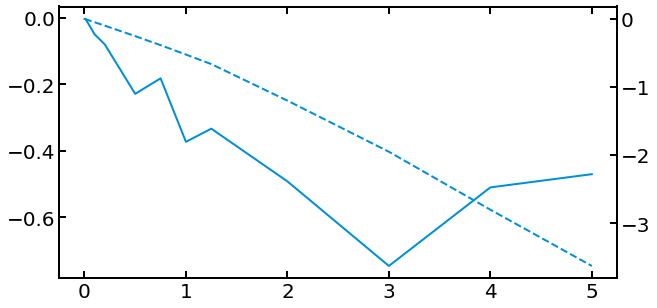

In [509]:
plt.plot(mu_vals, mean_lyap_specs)
ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(mu_vals, [lambda_2(mu)/2 for mu in mu_vals], linestyle='--')
plt.show()

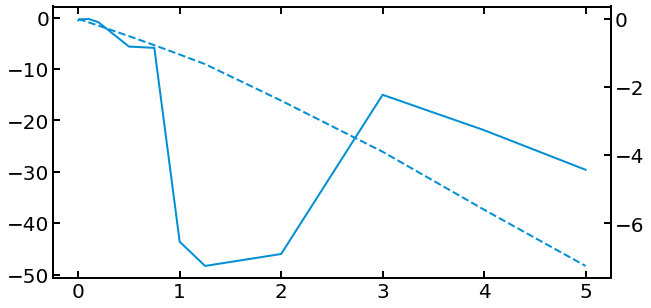

In [511]:
plt.plot(mu_vals, min_lyap_specs)
ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(mu_vals, [lambda_2(mu) for mu in mu_vals], linestyle='--')
plt.show()